# Research Question 2 - sentiment, ratings and box office  

This notebook does the ground work for answering the two subquestions related to research question 2 (stated in the ReadME). The problem and subquestions we aim at adressing are:      
    
    Sentiment analysis in quotes about movies over time. Additionaly relate sentiment to Box Office sales and see if positive/negative media coverage affect the sale of tickets.    
    
    - RQ2.1: Does the media/quoters opinion on a certain movie affect the amount of sold tickets?     
    - RQ2.2: Does the sentiment seen in quotes relate to the rating on IMDB? 
    
Conclusions will be drawn here and also used in the `milestone3` file in the main directory of the repo.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import plotly.express as px
import plotly
import re
import statsmodels.formula.api as smf
import seaborn as sns

### Load Box Office, IMDb and Quotebank

We start by loading the three regarded data sets from their respective pickles / csv-files that are investigated in the exploratory notebooks. We choose to load the Quotebank data with associated sentiment scores as it will be relevant to adress this RQ.

In [2]:
data_dir = os.getcwd() + os.sep + f'exploratory{os.sep}data'

# load pickled data
df_Quotebank = pd.read_pickle(rf"{data_dir}{os.sep}Quotebank_sentiment.pkl") 
df_boxOffice = pd.read_pickle(rf"{data_dir}{os.sep}boxOffice.pkl")   

# load IMDb csv-files and merge
movies = pd.read_csv(rf"{data_dir}{os.sep}IMDb{os.sep}IMDB movies.csv", low_memory=False)
ratings = pd.read_csv(rf"{data_dir}{os.sep}IMDb{os.sep}IMDB ratings.csv")    
df_imdb = movies.merge(ratings, on='imdb_title_id')


We check that these were correctly loaded by looking at the head of the dataframes.

In [3]:
df_Quotebank.head(3)

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,AFINN_label,AFINN_score,VADER_label,VADER_score,BERT_label,BERT_score,positive_BERT_score,scaledReverted_BERT_score
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751,POSITIVE,0.500000,POSITIVE,0.3612,NEGATIVE,0.989802,0.010198,-0.541032
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724,POSITIVE,0.165563,POSITIVE,0.9910,POSITIVE,0.999293,0.999293,0.787788
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692,NEGATIVE,-0.153846,NEGATIVE,-0.6369,NEGATIVE,0.833872,0.166128,-0.208302


In [4]:
df_boxOffice.head()

,days,dow,rank,daily,theaters,special events,movie
0,2019-05-24,Friday,1,31358935.0,4476,NaN,Aladdin
1,2019-05-25,Saturday,1,30013295.0,4476,NaN,Aladdin
2,2019-05-26,Sunday,1,30128699.0,4476,NaN,Aladdin
3,2019-05-27,Monday,1,25305033.0,4476,Memorial Day,Aladdin
4,2019-05-28,Tuesday,1,12014982.0,4476,NaN,Aladdin


In [5]:
df_imdb.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,6.2,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,5.8,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,5.5,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,7.3,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0


In [6]:
overlap = np.intersect1d(df_imdb.original_title.unique(), df_Quotebank.movie.unique())
print(overlap)
print(f"\nsize of overlap of movie titles: {overlap.__len__()}")

['Aladdin' 'Aquaman' 'Avengers: Age of Ultron' 'Avengers: Endgame'
 'Avengers: Infinity War' 'Bad Boys for Life'
 'Batman v Superman: Dawn of Justice' 'Beauty and the Beast'
 'Birds of Prey: And the Fantabulous Emancipation of One Harley Quinn'
 'Black Panther' 'Bohemian Rhapsody' 'Captain America: Civil War'
 'Captain Marvel' 'Deadpool' 'Deadpool 2' 'Despicable Me 3' 'Dolittle'
 'Fantastic Beasts and Where to Find Them'
 'Fantastic Beasts: The Crimes of Grindelwald' 'Fast & Furious 7'
 'Finding Dory' 'Frozen II' 'Guardians of the Galaxy Vol. 2'
 'Incredibles 2' 'Inside Out' 'Joker' 'Jumanji: The Next Level'
 'Jumanji: Welcome to the Jungle' 'Jurassic World'
 'Jurassic World: Fallen Kingdom' 'Minions'
 'Mission: Impossible - Fallout' 'Mission: Impossible - Rogue Nation'
 'Onward' 'Rogue One' 'Sonic the Hedgehog' 'Spectre'
 'Spider-Man: Far from Home' 'Spider-Man: Homecoming'
 'Star Wars: Episode IX - The Rise of Skywalker'
 'Star Wars: Episode VII - The Force Awakens'
 'Star Wars: Epis

We only make use of the movies that we restricted ourselves to in the Quotebank data. This is done below.

In [7]:
# choose movies
df_imdb = df_imdb[np.isin(df_imdb.original_title, overlap)]

# choose years
Quotebank_years = pd.Series([date.split("-")[0] for date in df_Quotebank.date.unique()]).unique()
df_imdb = df_imdb[np.isin(df_imdb.year, Quotebank_years)]

# update indeces
df_imdb.index = np.arange(len(df_imdb))

In [8]:
print(f"Shape of dataframe: {df_imdb.shape}")
df_imdb.head()

Shape of dataframe: (58, 70)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0
2,tt1051906,L'uomo invisibile,The Invisible Man,2020,2020-03-27,"Horror, Mystery, Sci-Fi",124,"Canada, Australia, USA",English,Leigh Whannell,...,7.1,6778.0,7.2,1603.0,6.9,373.0,7.2,15568.0,7.0,49787.0
3,tt1270797,Venom,Venom,2018,2018-10-04,"Action, Adventure, Sci-Fi",112,"China, USA","English, Mandarin, Malay",Ruben Fleischer,...,7.0,14589.0,7.2,3063.0,6.3,556.0,6.6,35509.0,6.6,125428.0
4,tt1386697,Suicide Squad,Suicide Squad,2016,2016-08-13,"Action, Adventure, Fantasy",123,USA,"English, Japanese, Spanish",David Ayer,...,6.2,27359.0,6.4,4816.0,5.7,740.0,5.9,60869.0,5.9,203451.0


We are only supposed to have 56 movies in the frame. Let's find out which ones are duplicated.

In [9]:
movies, freq = np.unique(df_imdb.original_title, return_counts=True)
movies[freq > 1]

array(['Joker', 'The Invisible Man'], dtype=object)

Let's investigate these and see which duplicate is the false one. Then we outfilter these ones.

In [10]:
df_imdb[df_imdb.original_title == 'Joker']

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
47,tt5611648,Joker,Joker,2016,2016-08-12,"Comedy, Drama",130,India,Tamil,"Raju Murugan, Raju Saravanan",...,8.1,22.0,8.0,2.0,6.6,19.0,8.1,171.0,8.2,870.0
54,tt7286456,Joker,Joker,2019,2019-10-03,"Crime, Drama, Thriller",122,"USA, Canada",English,Todd Phillips,...,8.4,35220.0,8.3,7620.0,7.9,630.0,8.2,77947.0,8.4,281183.0


In [11]:
df_imdb[df_imdb.original_title == 'The Invisible Man']

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
2,tt1051906,L'uomo invisibile,The Invisible Man,2020,2020-03-27,"Horror, Mystery, Sci-Fi",124,"Canada, Australia, USA",English,Leigh Whannell,...,7.1,6778.0,7.2,1603.0,6.9,373.0,7.2,15568.0,7.0,49787.0
55,tt7651078,The Invisible Man,The Invisible Man,2017,2018-02-04,Sci-Fi,88,USA,English,"Khian Bartlett, Carol Damgen",...,4.7,6.0,4.0,7.0,4.0,10.0,3.5,57.0,3.2,35.0


The rows to be removed are 47 and 55 - this can also be seen by the number of votes on the IMDb ratings.

In [12]:
df_imdb = df_imdb.drop([47, 55])
df_imdb.index = np.arange(len(df_imdb))
print(f"Shape of dataframe: {df_imdb.shape}")

Shape of dataframe: (56, 70)


In [13]:
df_imdb

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0
2,tt1051906,L'uomo invisibile,The Invisible Man,2020,2020-03-27,"Horror, Mystery, Sci-Fi",124,"Canada, Australia, USA",English,Leigh Whannell,...,7.1,6778.0,7.2,1603.0,6.9,373.0,7.2,15568.0,7.0,49787.0
3,tt1270797,Venom,Venom,2018,2018-10-04,"Action, Adventure, Sci-Fi",112,"China, USA","English, Mandarin, Malay",Ruben Fleischer,...,7.0,14589.0,7.2,3063.0,6.3,556.0,6.6,35509.0,6.6,125428.0
4,tt1386697,Suicide Squad,Suicide Squad,2016,2016-08-13,"Action, Adventure, Fantasy",123,USA,"English, Japanese, Spanish",David Ayer,...,6.2,27359.0,6.4,4816.0,5.7,740.0,5.9,60869.0,5.9,203451.0
5,tt1431045,Deadpool,Deadpool,2016,2016-02-18,"Action, Adventure, Comedy",108,USA,English,Tim Miller,...,7.9,41239.0,7.9,7845.0,7.5,804.0,8.1,91566.0,7.8,309504.0
6,tt1477834,Aquaman,Aquaman,2018,2019-01-01,"Action, Adventure, Fantasy",143,"USA, Australia","English, Russian, Maori, Italian",James Wan,...,6.9,16691.0,7.1,4411.0,6.6,594.0,6.9,38872.0,6.8,121047.0
7,tt1502397,Bad Boys for Life,Bad Boys for Life,2020,2020-02-20,"Action, Comedy, Crime",124,"USA, Mexico","English, Spanish","Adil El Arbi, Bilall Fallah",...,6.8,4338.0,6.8,1149.0,6.1,315.0,6.7,12297.0,6.5,42309.0
8,tt1727824,Bohemian Rhapsody,Bohemian Rhapsody,2018,2018-11-29,"Biography, Drama, Music",134,"UK, USA","English, British Sign Language",Bryan Singer,...,8.3,29897.0,8.6,9605.0,7.2,609.0,7.8,45282.0,7.9,161478.0
9,tt1825683,Black Panther,Black Panther,2018,2018-02-14,"Action, Adventure, Sci-Fi",134,USA,"English, Swahili, Nama, Xhosa, Korean",Ryan Coogler,...,7.6,28085.0,7.8,7494.0,6.8,679.0,7.6,78364.0,7.0,196556.0


## RQ 2.1: Sentiment and Box Office

We aim at investigating whether the sentiment related to movies can be seen as correlated to the Box Office revenue related to movies. To do this we first need to account for consistency between the Box Office and the Quotebank data sets. Below we change the days/date attribute to be consistent. Furthermore, as explained in the `Quotebank_sentiment.ipynb` notebook we will use the transformer based (BERT) sentiment score from `HuggingFace`. This score was saved in the Quotebank dataframe as the probability of being positive between 0 and 1 - this is now reexpressed on a scale between -1 and 1 for being able to express negative Quotes and have a better and more intuitive representation of negative sentiment.

In [14]:
# rename for consistency between data sets
df_Quotebank = df_Quotebank.rename(columns={'date': 'days'})

# re-express positive bert score for intuition of negative values
df_Quotebank['positive_BERT_score'] = 2 * (df_Quotebank.positive_BERT_score - 0.5)
df_Quotebank.positive_BERT_score

# attributes of interest
aoi = ['movie', 'days', 'BERT_label', 'multiplied_BERT', 'VADER_label', 'multiplied_VADER']

### Multiplied daily sentiment
As the Box Office sales are the total revenue for the movie across all movie theaters we will follow a similar approach when considering the sentiment of quotes for this research sub-question. Thus, we will multiply the daily sentiment of a quote about a movie with its number of occurrences and sum this multiplied sentiment for all quotes occuring at each date related to a movie. This approach is similar to the Box Office for which reason we find them comparable. In research (sub)question 2.2 we will use a different approach that is better related to the IMDb data set.

In [15]:
df_Quotebank['multiplied_VADER'] = df_Quotebank.numOccurrences * df_Quotebank.VADER_score
df_Quotebank['multiplied_BERT'] = df_Quotebank.numOccurrences * df_Quotebank.positive_BERT_score

In [16]:
multSum_per_day = df_Quotebank[aoi].groupby(['movie', 'days']).sum()
multSum_per_day.describe()

,multiplied_BERT,multiplied_VADER
count,12717.000000,12717.000000
mean,3.710182,1.582479
std,12.279737,7.717111
min,-158.377222,-187.232100
25%,-0.930393,-0.273200
50%,0.999746,0.773400
75%,4.982895,2.752100
max,430.519033,128.797100


In [17]:
multSum_per_day

multiplied_BERT  multiplied_VADER
movie    days                                         
Aladdin  2019-01-02         0.998775            0.9929
         2019-01-03         1.353582            0.2732
         2019-01-08         0.169957            0.5464
         2019-01-13         0.999398            0.8720
         2019-01-15         1.994038            0.9725
...                              ...               ...
Zootopia 2017-11-13        -0.965401            0.0000
         2017-12-07        -0.034033            0.0000
         2017-12-20         0.997421            0.6808
         2017-12-26         0.727826            0.4404
         2017-12-27        -0.997922            0.6880

[12717 rows x 2 columns]

We see that the summations seems to be correctly made but realize that there is much more data in the quotebank data than in the box office data. As we investigate whether the relation between sentiment of quotes correlate with the box office sales we restrict ourselves to the period for a movie determine by the airing time in the cinemas, such that we use all of the dates from the box office data but disregard quotes appearing after the movie was taken of the screen. We do this by creating a merged data frame.

In [23]:
merged_df = df_boxOffice.drop('special events', axis=1).merge(multSum_per_day, on=['movie', 'days'], how='left')
merged_df

,days,dow,rank,daily,theaters,movie,multiplied_BERT,multiplied_VADER
0,2019-05-24,Friday,1,31358935.0,4476,Aladdin,21.811739,16.0772
1,2019-05-25,Saturday,1,30013295.0,4476,Aladdin,3.891365,3.1421
2,2019-05-26,Sunday,1,30128699.0,4476,Aladdin,3.029213,0.7860
3,2019-05-27,Monday,1,25305033.0,4476,Aladdin,4.431028,-0.5205
4,2019-05-28,Tuesday,1,12014982.0,4476,Aladdin,19.273443,-6.4471
...,...,...,...,...,...,...,...,...
6900,2016-07-31,Sunday,43,2144.0,24,Zootopia,NaN,NaN
6901,2016-08-01,Monday,43,845.0,24,Zootopia,NaN,NaN
6902,2016-08-02,Tuesday,43,904.0,24,Zootopia,0.986622,0.7964
6903,2016-08-03,Wednesday,45,865.0,24,Zootopia,NaN,NaN


In [29]:
merged_df.isnull().any()

days                False
dow                 False
rank                False
daily               False
theaters            False
movie               False
multiplied_BERT      True
multiplied_VADER     True
dtype: bool

So this reveals that some of the days for which box office data is available does not have an associated sentiment score, meaning that no quotes about the movie occured this day. We do not regard these as outliers and choose to apply a neutral sentiment score (equal to zero) to these days having a `NaN`-value as sentiment.

In [30]:
merged_df.fillna(0, inplace=True)
merged_df

,days,dow,rank,daily,theaters,movie,multiplied_BERT,multiplied_VADER
0,2019-05-24,Friday,1,31358935.0,4476,Aladdin,21.811739,16.0772
1,2019-05-25,Saturday,1,30013295.0,4476,Aladdin,3.891365,3.1421
2,2019-05-26,Sunday,1,30128699.0,4476,Aladdin,3.029213,0.7860
3,2019-05-27,Monday,1,25305033.0,4476,Aladdin,4.431028,-0.5205
4,2019-05-28,Tuesday,1,12014982.0,4476,Aladdin,19.273443,-6.4471
...,...,...,...,...,...,...,...,...
6900,2016-07-31,Sunday,43,2144.0,24,Zootopia,0.000000,0.0000
6901,2016-08-01,Monday,43,845.0,24,Zootopia,0.000000,0.0000
6902,2016-08-02,Tuesday,43,904.0,24,Zootopia,0.986622,0.7964
6903,2016-08-03,Wednesday,45,865.0,24,Zootopia,0.000000,0.0000


In [31]:
merged_df.isnull().any()

days                False
dow                 False
rank                False
daily               False
theaters            False
movie               False
multiplied_BERT     False
multiplied_VADER    False
dtype: bool

As we want to investigate whether the trend of high sentiment of quotes correlating with high box office revenue we sum the sentiment and box office time series data over all dates (of airing time) for each movie. A snippet is seen below.

In [32]:
merged_df.groupby('movie').sum().head()

,rank,daily,theaters,multiplied_BERT,multiplied_VADER
movie,,,,,
Aladdin,2485,355559216.0,249321,90.238282,143.4030
Aquaman,1266,335061807.0,222107,185.882581,229.8329
Avengers: Age of Ultron,551,455530367.0,196219,79.099213,88.9659
Avengers: Endgame,2014,858373000.0,264340,177.828269,253.7383
Avengers: Infinity War,2399,678815482.0,240842,556.993335,323.5690


Similarly to our approach in RQ1 we start by investigating whether there is a tendency on the movie level. We try to model the sum of daily box office income with the predictor being the sum of summed daily sentiment from quotes to see if the sentiment affect the daily income.

In [33]:
mod = smf.ols(formula='daily ~ multiplied_BERT', data=merged_df.groupby('movie').sum())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  daily   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     9.884
Date:                Mon, 13 Dec 2021   Prob (F-statistic):            0.00271
Time:                        11:46:35   Log-Likelihood:                -1140.6
No. Observations:                  56   AIC:                             2285.
Df Residuals:                      54   BIC:                             2289.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.298e+08   2.56e+07     

As we see, the p-value is lower than our significance level of 5% and it can therefore be said that the total sentiment is a significant predictor when it comes to predicting the total box office revenue. From the coefficient we see that there is a positive correlation between the multiplied BERT score and the overall box office sales. However, we see from the R^2 score that the fitted model is not super good, which is also visualized in the figure below.

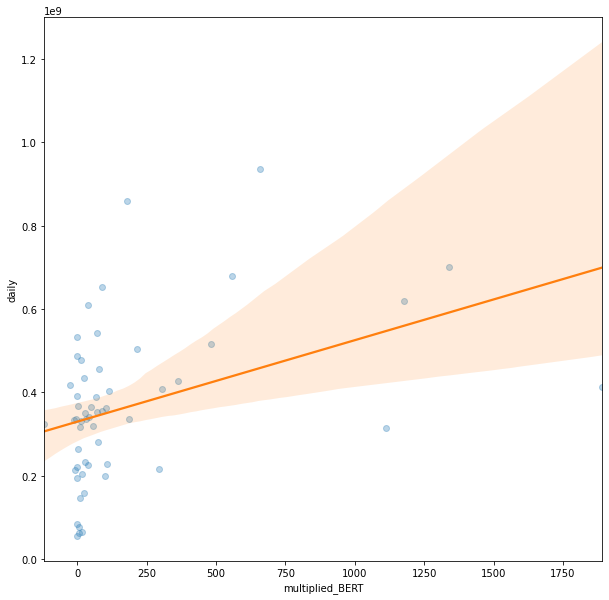

In [34]:
plt.figure(figsize = (10,10))
sns.regplot(data=merged_df.groupby('movie').sum(), x='multiplied_BERT', y='daily',
            line_kws = {'color': 'C1'},
            scatter_kws = {'color': 'C0', 'alpha': 0.3})
plt.show()

As the fitted regression is not super good when not encountering the time-series of the box office and sentiment, we choose to try a different approach (as in RQ1). We will analyze movies independently and instead investigate whether box office can be seen as being Granger causal from the multiplied sentiment scores. An example of the time series (box office and sentimennt) related to Avengers: Endgame is visualized below.

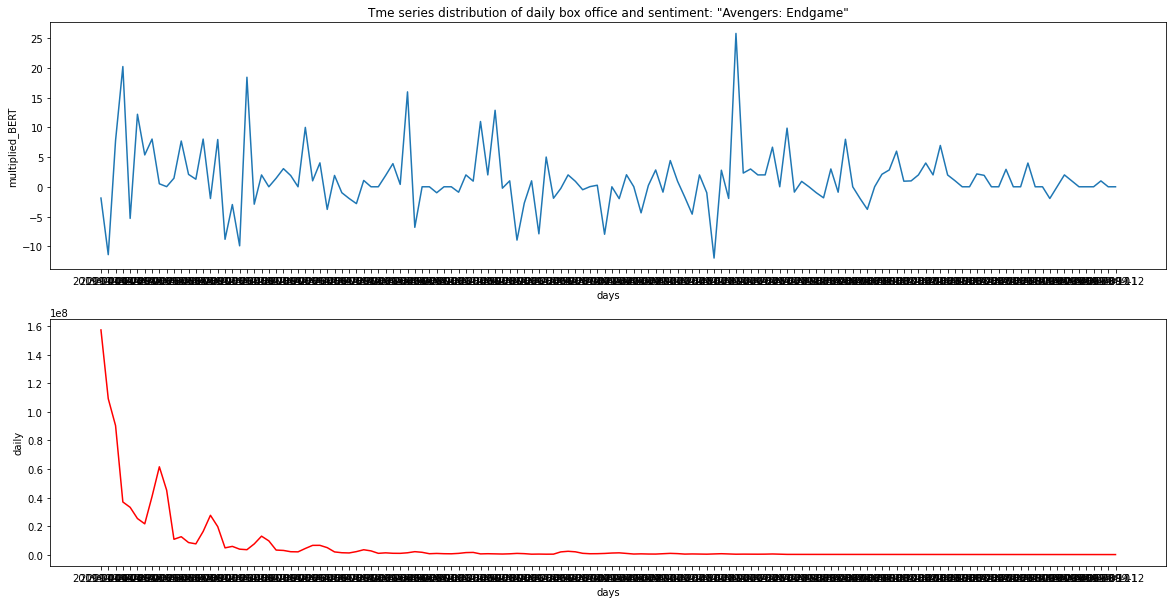

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,10))
ax[0].set(title='Tme series distribution of daily box office and sentiment: "Avengers: Endgame"')
sns.lineplot(x='days', y='multiplied_BERT', data=merged_df[merged_df.movie=='Avengers: Endgame'], ax=ax[0])
sns.lineplot(x='days', y='daily', data=merged_df[merged_df.movie=='Avengers: Endgame'], ax=ax[1], color='red')
plt.show()

We will apply the Granger causality test to all the movies to check whether there is a significant relation (that box office can be seen as being caused by sentiment, following granger terms) between box office sales and the sentiment score when analyzing time series on the individual movie level. We use the same code as in RQ1 but adjust the maximum lag to 3 as we are using the test on all movies, where some movies do not have as much time-points as others. In fact, some movies - like "Spider-Man: Homecoming" - has no sentiment attached to it for all days where it was airing in the cinemas, for which reason we try out the Granger approach and only compute it for movies that have a sufficient amount of quotes per box office day.

In [107]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=3
test = 'ssr_chi2test'

# code found here: https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [180]:
sent_cause_box = {}
#box_cause_sent = {}

for i, movie in enumerate(merged_df.movie.unique()): 
    print(f"\n {movie}")
    time_series = merged_df[merged_df.movie == movie].set_index('days')
    try:
        gcm = grangers_causation_matrix(time_series[['daily', 'multiplied_BERT']], variables = ['daily', 'multiplied_BERT'], verbose=True)

        sent_box = gcm.loc['daily_y', 'multiplied_BERT_x']
        sent_cause_box[movie] = (sent_box, sent_box < 0.05)
        
        #box_sent = gcm.loc['multiplied_BERT_y', 'daily_x']
        #box_cause_sent[movie] = (box_sent, box_sent < 0.05)
        
    except:
        pass


 Aladdin
Y = daily, X = daily, P Values = [1.0, 1.0, 1.0]
Y = multiplied_BERT, X = daily, P Values = [0.2173, 0.0472, 0.3145]
Y = daily, X = multiplied_BERT, P Values = [0.4509, 0.7732, 0.0007]
Y = multiplied_BERT, X = multiplied_BERT, P Values = [1.0, 1.0, 1.0]

 Aquaman
Y = daily, X = daily, P Values = [1.0, 1.0, 1.0]
Y = multiplied_BERT, X = daily, P Values = [0.8315, 0.442, 0.342]
Y = daily, X = multiplied_BERT, P Values = [0.0054, 0.0026, 0.7936]
Y = multiplied_BERT, X = multiplied_BERT, P Values = [1.0, 1.0, 1.0]

 Avengers: Age of Ultron
Y = daily, X = daily, P Values = [1.0, 1.0, 1.0]
Y = multiplied_BERT, X = daily, P Values = [0.4434, 0.3391, 0.2897]
Y = daily, X = multiplied_BERT, P Values = [0.4547, 0.108, 0.1952]
Y = multiplied_BERT, X = multiplied_BERT, P Values = [1.0, 1.0, 1.0]

 Avengers: Endgame
Y = daily, X = daily, P Values = [1.0, 1.0, 1.0]
Y = multiplied_BERT, X = daily, P Values = [0.5781, 0.0069, 0.0006]
Y = daily, X = multiplied_BERT, P Values = [0.3847, 0.0056


 Mission: Impossible - Fallout
Y = daily, X = daily, P Values = [1.0, 1.0, 1.0]

 Sonic the Hedgehog
Y = daily, X = daily, P Values = [1.0, 1.0, 1.0]
Y = multiplied_BERT, X = daily, P Values = [0.0, 0.1167, 0.0032]
Y = daily, X = multiplied_BERT, P Values = [0.0417, 0.0473, 0.0055]
Y = multiplied_BERT, X = multiplied_BERT, P Values = [1.0, 1.0, 1.0]

 Spectre
Y = daily, X = daily, P Values = [1.0, 1.0, 1.0]
Y = multiplied_BERT, X = daily, P Values = [0.0114, 0.0, 0.0]
Y = daily, X = multiplied_BERT, P Values = [0.0031, 0.0, 0.0]
Y = multiplied_BERT, X = multiplied_BERT, P Values = [1.0, 1.0, 1.0]

 Mission: Impossible - Rogue Nation
Y = daily, X = daily, P Values = [1.0, 1.0, 1.0]

 Rogue One
Y = daily, X = daily, P Values = [1.0, 1.0, 1.0]
Y = multiplied_BERT, X = daily, P Values = [0.8472, 0.9499, 0.9523]
Y = daily, X = multiplied_BERT, P Values = [0.9353, 0.9779, 0.995]
Y = multiplied_BERT, X = multiplied_BERT, P Values = [1.0, 1.0, 1.0]

 Star Wars: Episode IX - The Rise of Skywal

In [187]:
sent2box = np.array([(movie, p_val, reject) for movie, (p_val, reject) in sent_cause_box.items()])

So an example of the p-values are shown below they are summarized in the first coming plot.

In [199]:
temp = pd.DataFrame(sent2box).rename(columns={0: 'movie', 1: 'p_vals', 2: 'reject'})
temp.head()

,movie,p_vals,reject
0,Aladdin,0.0007,True
1,Aquaman,0.0026,True
2,Avengers: Age of Ultron,0.108,False
3,Avengers: Endgame,0.0002,True
4,Avengers: Infinity War,0.2322,False


In [222]:
import plotly.express as px

fig = px.bar(x=temp.reject, y=(np.ones(len(temp.reject))), labels={'x':'based on p-values < 0.05', 'y':'count'},
            hover_name =temp.movie,
            color=temp.reject, #sent2box[:,0],
            color_discrete_sequence=['#B51F1F', '#00A79F'],
            title='Do the daily sentiment influence the daily Box Office sales?')
fig.show()

So there does not seem to be a complete agreeing that the time series sentiment of a movie influence the time series box office of the same movie, but we see that it seems like there's a larger fraction of movies where the Box Office temporal data can be said to be Granger caused by the daily multiplied sentiment of the movie.

But wait a minute! This is a multiple comparisons problem as we are investigating several statistical tests at once. Let's first adjust the p-values with the Bonferroni method to account for false-positives before making further conclusions.

In [223]:
from statsmodels.stats.multitest import multipletests

In [224]:
reject_sent2box, adj_pvals_sent2box, _, _ = multipletests(sent2box[:,1].astype(float), alpha=0.05, method='bonferroni')
reject_box2sent, adj_pvals_box2sent, _, _ = multipletests(p_vals_box2sent, alpha=0.05, method='bonferroni')

In [225]:
adj_pvals_df = pd.DataFrame(adj_pvals_sent2box, reject_sent2box)
adj_pvals_df['movie'] = sent2box[:,0]
adj_pvals_df = adj_pvals_df.reset_index().rename(columns={0: 'p_vals', 'index': 'reject'})
adj_pvals_df.head()

,reject,p_vals,movie
0,True,0.0357,Aladdin
1,False,0.1326,Aquaman
2,False,1.0000,Avengers: Age of Ultron
3,True,0.0102,Avengers: Endgame
4,False,1.0000,Avengers: Infinity War


In [226]:
import plotly.express as px

fig = px.bar(x=adj_pvals_df.reject, y=(np.ones(len(adj_pvals_df.reject))), labels={'x':'based on adjusted p-values < 0.05', 'y':'count'},
            hover_name =adj_pvals_df.movie,
            color=adj_pvals_df.reject, #sent2box[:,0],
            color_discrete_sequence=['#B51F1F', '#00A79F'],
            title='Do the daily sentiment influence the daily Box Office sales?')
fig.show()

Indeed we do not see the same tendency in when looking at the statistical results based on the adjusted p-values. These are more valid and hence we conclude that even though the multiplied sentiment scores can be regarded as causing (in the sense of Granger causality) the Box Office sales for some movies, it is not the typical tendency. 

**Conclusion:** Even though the linear regression between multiplied BERT sentiment and Box Office sales are linearly related when examining the attributes without the temporal, we believe that the fit is too bad for the total sentiment scores for movies to be a good predictor on the total Box Office sales for movies. We furthermore see that the daily box office sales for some movies can be said to be caused (Granger causality) by the daily multiplied BERT sentiment of quotes but that the majority of movies do not have this relation between daily multiplied sentiment and daily box office sales.

### Weighted daily average sentiment - (WIP)

In [227]:
temp_BERT = {}
temp_VADER = {}

for (movie, date), subframe in tqdm(df_Quotebank.groupby(['movie', 'days'])):    
    weighted_average_BERT = (subframe.numOccurrences * subframe.positive_BERT_score).sum() / subframe.numOccurrences.sum() 
    weighted_average_VADER = (subframe.numOccurrences * subframe.VADER_score).sum() / subframe.numOccurrences.sum()
    
    temp_BERT[(movie, date)] = weighted_average_BERT
    temp_VADER[(movie, date)] = weighted_average_VADER
    
wAvg_per_day = pd.DataFrame([pd.Series(temp_BERT), pd.Series(temp_VADER)]).T
wAvg_per_day = wAvg_per_day.rename(columns={0: 'weighted_BERT', 1: 'weighted_VADER'})
wAvg_per_day.index.names = ['movie', 'days']
wAvg_per_day

  0%|          | 0/12717 [00:00<?, ?it/s]

weighted_BERT  weighted_VADER
movie    days                                     
Aladdin  2019-01-02       0.998775        0.992900
         2019-01-03       0.676791        0.136600
         2019-01-08       0.056652        0.182133
         2019-01-13       0.999398        0.872000
         2019-01-15       0.997019        0.486250
...                            ...             ...
Zootopia 2017-11-13      -0.965401        0.000000
         2017-12-07      -0.034033        0.000000
         2017-12-20       0.997421        0.680800
         2017-12-26       0.727826        0.440400
         2017-12-27      -0.997922        0.688000

[12717 rows x 2 columns]

In [234]:
new_merged_df = df_boxOffice.drop('special events', axis=1).merge(wAvg_per_day, on=['movie', 'days'], how='left')
new_merged_df.head()

,days,dow,rank,daily,theaters,movie,weighted_BERT,weighted_VADER
0,2019-05-24,Friday,1,31358935.0,4476,Aladdin,0.559275,0.412236
1,2019-05-25,Saturday,1,30013295.0,4476,Aladdin,0.972841,0.785525
2,2019-05-26,Sunday,1,30128699.0,4476,Aladdin,0.605843,0.157200
3,2019-05-27,Monday,1,25305033.0,4476,Aladdin,0.553879,-0.065062
4,2019-05-28,Tuesday,1,12014982.0,4476,Aladdin,0.876066,-0.293050


In [235]:
new_merged_df.isnull().any()

days              False
dow               False
rank              False
daily             False
theaters          False
movie             False
weighted_BERT      True
weighted_VADER     True
dtype: bool

In [237]:
new_merged_df.fillna(0, inplace=True)
new_merged_df.isnull().any()

days              False
dow               False
rank              False
daily             False
theaters          False
movie             False
weighted_BERT     False
weighted_VADER    False
dtype: bool

## RQ 2.2: Sentiment and IMDb - (WIP)

### Narrowing in the data frame to the use-case

We start by cutting down the dataframe to its essence that is related to this research (sub)question. Other than the descriptive information about the movies, we need ratings from users, critics and eventually the distribution of votes across specific ratings. We might want to analyse the description of the movie too. Here are the attributes we keep so far (we might extend the selection later):

`original_title` is the movie title agreeing with the Quotebank data.''

`genre` is the movie genre.

`year` is the year.

`date_published` is the release date of the movie.

`description` is a description about the movie. 

`metascore` is a rating of the film based on the world's most respective critics (weighted average). Possible maximum is 100. 

`weighted_average_vote` is the score IMDb weighted average rating. This is what appears on the IMDb webpage and is based on users votes. Possible maximum is 10.

`votes` is the total number of votes.

`votes_[1-10]` is number of votes with the specific rating.


In [ ]:
votes_n = [f"votes_{n}" for n in range(1,11)]
print(votes_n)

In [ ]:
# attributes of interest
aoi = np.union1d(votes_n, ['original_title', 'genre', 'year', 'date_published', 'description', 'metascore', 'weighted_average_vote']).tolist()

print("Attributes to keep:")
aoi

In [ ]:
df_imdb = df_imdb[aoi]
df_imdb.head()

We then want to calculate a representative sentiment score associated with each movie, that can eventually be scaled and compared with the IMDb ratings by users and critics. 

What we do now is different than in the box office approach. We still want to account for the importance of the number of occurrences of a quote related to a movie, but since we aim at comparing the sentiment scores for movies to the IMDb rating we cannot multiply and sum the sentiments on a given day, as sentiment scores can possibly be infinite positive or negative with that approach. Instead we calculate a daily sentiment score for each movie as the weighted average of the sentiment scores for all quotes related to the given movie on that day, where the number of occurrences is used as the weighting term. This is done by iterating through the `groupby` object that is created when grouping Quotebank by movie and dates.

In [ ]:
temp_BERT = {}
temp_VADER = {}

for (movie, date), subframe in tqdm(df_Quotebank.groupby(['movie', 'days'])):    
    weighted_average_BERT = (subframe.numOccurrences * subframe.positive_BERT_score).sum() / subframe.numOccurrences.sum() 
    weighted_average_VADER = (subframe.numOccurrences * subframe.VADER_score).sum() / subframe.numOccurrences.sum()
    
    temp_BERT[(movie, date)] = weighted_average_BERT
    temp_VADER[(movie, date)] = weighted_average_VADER

In [ ]:
wAvg_per_day = pd.DataFrame([pd.Series(temp_BERT), pd.Series(temp_VADER)]).T
wAvg_per_day = wAvg_per_day.rename(columns={0: 'weighted_BERT', 1: 'weighted_VADER'})
wAvg_per_day.index.names = ['movie', 'days']
wAvg_per_day

And by using the `describe` method of pandas we clearly see that the max- and minimum range is definetely bounded in the interval [-1, 1] that the re-expressed positive BERT scores also are.

In [ ]:
wAvg_per_day.describe()

When investigating the sentiment of quotes' relation to the box office sales we were restricted to the time period in which the movie was airing in the movie theaters. This is however not the case for IMDb as the data set does not contain the IMDb scores as a time series but solely as single values. We therefore find it relevant to use all of the quotes as the IMDb score is based on running votes/ratings and can have been affected by sentiment of quotes at all time points.

For this reason we simply average the daily sentiment scores for each movie to obtain the final sentiment score associated with the movies. We provide a snippet below.

In [ ]:
sents_movie = wAvg_per_day.groupby('movie').mean()
sents_movie.head()

As we are interested in changing the scaling of this score to a predefined scaling, we make use of normalization. It resembles the min-max normalization we encountered in the lectures but differ by using our knowledge of the range of the scale that the data is on rather than using the minimum and maximum observed sentiment scores. Thus the formula for rescaling data in the range $[s_{low}, s_{high}]$ to the range $[t_{low}, t_{high}]$ looks as follows to ca:

$$
(t_{high}-t_{low}) \frac{x - s_{low}}{s_{high}-s_{low}} + t_{low}
$$

The sentiment range theoretically lies between [-1, 1] and IMDb scores can theoretically lie between [1, 10] if all quotes or votes, respectively, about a movie are at the extreme values. Thus, the sentiment scores become:

In [ ]:
sents_movie = np.round((10-1) * (sents_movie + 1) / 2 + 1, 2)
sents_movie.head()

In [ ]:
sents_movie.describe()

And the sentiment scores are in fact now within that range :-) 
Let's see if the distribution of sentiment scores resemble the `weighted_average_score` that is based on IMDb users or the `metascore` that are based on critics opinion. We need to rescale `metascore` that has the possible range [0, 100].

In [ ]:
metascore = (10-1) * df_imdb.metascore / 100 + 1
df_imdb.loc[:, 'metascore'] = metascore
metascore.head()

Let's add everything to the imdb dataframe and describe it!

In [ ]:
merged_df = df_imdb.merge(sents_movie, how='left', left_on=['original_title'], right_on=['movie']).set_index('original_title')
merged_df = merged_df[['weighted_average_vote', 'metascore', 'weighted_BERT', 'weighted_VADER']]
merged_df.describe()

So, by looking at the descriptive statistics of the scores neither the weighted BERT nor VADER seem to be that far from modelling the IMDb trends. This is further seen in the plots below.

In [ ]:
merged_df.boxplot(figsize=((16,6)), grid=False)
plt.show()

In [ ]:
merged_df.hist(bins=11, figsize=((16,6)), grid=False, edgecolor='white', linewidth=1, alpha=0.65, sharex=True)[0]
plt.xlabel('score')
plt.ylabel('count')
plt.show()

But what about more advanced statistics than just examining the distributions and instead looking at how these scores relate together using a statistical test.

In [ ]:
import statsmodels.api as sm

In [ ]:
sns.scatterplot(x='weighted_BERT', y='weighted_average_vote', data=merged_df)
sns.scatterplot(x='weighted_BERT', y='metascore', data=merged_df)
plt.legend()

In [ ]:
mod = smf.ols(formula='metascore ~ weighted_BERT', data=merged_df)
res = mod.fit()
print(res.summary())

In [ ]:
mod = smf.ols(formula='weighted_average_vote ~ weighted_BERT', data=merged_df)
res = mod.fit()
print(res.summary())

Cool idea (too few data?): Supervised learning with IMDb scores as labels and quote sentiment used to model it.

BIG main question: Does the coverage sentiment influence the revenue? Bad coverage?

56 box office (total), 56 sentiment (mean/total)  -  schmirnoff  -linear regression?

Look at some specific movies!

In [ ]:
import plotly.express as px

movie = 'Star Wars: Episode VII - The Force Awakens'
sent_type = 'VADER'

fig = px.bar(x=df_combined.days, y=df_combined[f'daily_{sent_type}_movie'], labels={'x':'date', 'y':f'{sent_type} sentiment'},
            color=df_combined.movie,
             #color_discrete_sequence=['indianred'],
            title=f'sentiment for {movie}')

fig.show()

movie = 'Star Wars: Episode VII - The Force Awakens'
sent_type = 'BERT'

fig = px.bar(x=df_combined.days, y=df_combined[f'daily_{sent_type}_movie'], labels={'x':'date', 'y':f'{sent_type} sentiment'},
            color=df_combined.movie,
            #color_discrete_sequence=['indianred'],
            title=f'sentiment for {movie}')

fig.show()

In [ ]:
import plotly.express as px

movie = 'Star Wars: Episode VII - The Force Awakens'
sent_type = 'VADER'

fig = px.bar(x=df_combined[df_combined.movie==movie].days, y=df_combined[df_combined.movie==movie][f'daily_{sent_type}_movie'], labels={'x':'date', 'y':f'{sent_type} sentiment'},
            color_discrete_sequence=['indianred'],
            title=f'sentiment for {movie}')

fig.show()

movie = 'Star Wars: Episode VII - The Force Awakens'
sent_type = 'BERT'

fig = px.bar(x=df_combined[df_combined.movie==movie].days, y=df_combined[df_combined.movie==movie][f'daily_{sent_type}_movie'], labels={'x':'date', 'y':f'{sent_type} sentiment'},
            color_discrete_sequence=['indianred'],
            title=f'sentiment for {movie}')

fig.show()

In [ ]:
# transformer
from transformers import pipeline
classifier = pipeline("sentiment-analysis")

In [ ]:
sent_description = pd.Series([classifier(description) for description in tqdm(df_imdb['description'])])